We cover various machine learning algorithms applied to the MNIST handwritten digits dataset.

## MNIST handwritten digits dataset links
- https://github.com/richcorrado/MNIST-digits/MNIST_Digits-overview.ipynb
- <http://yann.lecun.com/exdb/mnist/>
- <https://www.kaggle.com/c/digit-recognizer>
- <https://pjreddie.com/projects/mnist-in-csv/>
- <https://groups.google.com/forum/#!topic/fat-cat-kagglers/c4Pv5kYiJzQ> 

## python scientific computing stack 

The python scientific computing library is not monolithic: it's built from a variety of packages from different sources. Some of these are:
- numpy: various math tools, especially for constructing and working with multidimensional arrays.
- scipy: python scientific computing library
- matplotlib: 2d plotting tools.
- pandas: dataframe data structure based on the one in R, along with vectorized routines for fast manipulation of the data
- sklearn: python ML toolbox
- seaborn: plotting
- bokeh: plotting



# Support Vector Machines
Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

A SVM constructs a hyperplane or (for multi-class) a set of hyperplanes in a high dimensional space with the largest distance to the nearest training data points of any class (functional margin). In general, the larger the margin the lower the generalization error of the classifier.

The **advantages** of support vector machines include:

* Effective in high dimensional spaces.
* Effective in cases where # Features > # Samples.
* Memory efficient
* Versatile: different Kernel functions can be specified for the decision function

The **disadvantages** of support vector machines include:

* Low performances when # Features >> # Samples.
* Low performance if the data is non-separable, until you make it separable with the appropriate kernel.

In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [2]:
from collections import Counter

import numpy as np
import pandas as pd
import scipy as sp

import sklearn
from sklearn import svm, metrics, preprocessing, neighbors
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier

from matplotlib.colors import ListedColormap

from IPython.display import display_html, HTML

import re

# this graphics stuff is not used yet
#import bokeh.plotting as bk
#from bokeh.models.mappers import LinearColorMapper
#from pandas.tools.plotting import scatter_matrix

# I don't seem to have this installed yet
#import addutils.palette as pal
#import seaborn as sns

In [3]:
# set display options
pd.set_option('display.precision',10)
pd.set_option('display.max_colwidth',100)
plt.rcParams['figure.figsize'] = 12, 4
get_ipython().magic(u'matplotlib notebook')

# Dataset

In [4]:
train_df = pd.read_csv("./input/train.csv")
#test_df = pd.read_csv("./input/test.csv")

In [5]:
# Data size overview
print('Training dataframe shape:', train_df.shape)
#print('Test dataframe shape:', test_df.shape)

Training dataframe shape: (42000, 785)


## Looking at the data

In [6]:
#print('test dataframe first rows:')
#display_html(test_df.head(5).style)
print('training dataframe first rows:')
train_df.head(5).style

training dataframe first rows:


In [7]:
# Define some helper functions to show us the data.

def pixel_mat(row, n=28, df = train_df):
    """ Convert a 1 by n^2 row into a n by n matrix 
    via np.reshape, dropping label if present"""
    vec = df.drop('label', axis=1).iloc[row].values
    return vec.reshape(n,n)

def plot_random_digits_in_grid(n=3, m=8, figsize=(16,8), df = train_df):
    plt.figure(figsize=figsize)
    # compute random indices
    indices = [np.random.randint(0, len(df)) for i in range(0,n*m)]
    # print labels
    for i in range(0, n*m):
        print(df.ix[indices[i]].label,end=',;'[i%m==m-1]) # silly print trick
    # matshow image
    for i in range(0, n*m):
        plt.subplot(n, m, i + 1) # creates a "subplot" in 1-indexed position
        ax = plt.gca() # get current axis
        ax.set_title(df.ix[indices[i]].label)
        x = indices[i]
        ax.matshow(pixel_mat(x, df=df), cmap=plt.cm.gray)
        train_df['label'].iloc[x]
    plt.show()
    return indices

5,7,4,4;6,2,1,9;4,6,6,4;

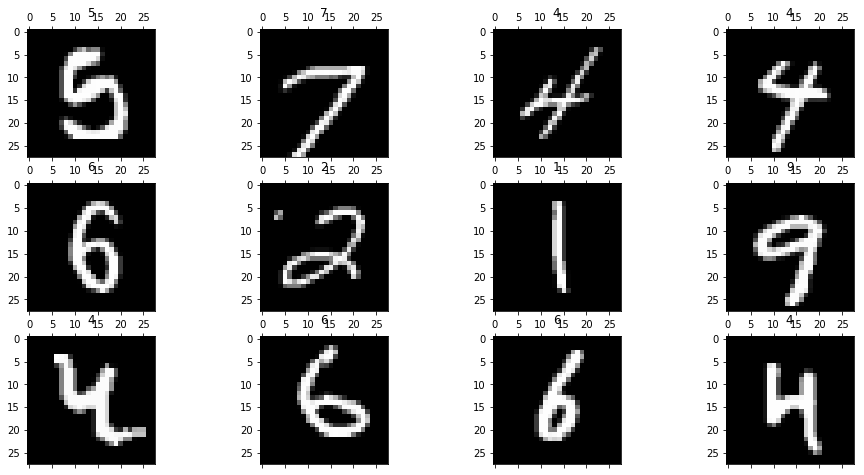

In [82]:
# we don't need interactivity here, so we use inline rather than notebook
% matplotlib inline

indices = plot_random_digits_in_grid(3, 4)

In [9]:
# There is a native python interface for counting duplicates ...
print ('Number of labels with a given count:', Counter(train_df['label']))
# There is also a pandas interface ... 
pd.DataFrame({ 
    'percentage' : train_df.label.value_counts( 
        normalize = True, sort = False ) * 100
}).round(4)

Number of labels with a given count: Counter({1: 4684, 7: 4401, 3: 4351, 9: 4188, 2: 4177, 6: 4137, 0: 4132, 4: 4072, 8: 4063, 5: 3795})


,percentage
0,9.8381
1,11.1524
2,9.9452
3,10.3595
4,9.6952
5,9.0357
6,9.8500
7,10.4786
8,9.6738
9,9.9714


## Test/Train Splits via scikit-learn
See the previous notebook for detailed description.

In [10]:
# We will call the labels y, and the data x. We need to further split the "training" dataset, because
# the test data set was provided without labels, which are necessary to check the results.

y_train = train_df['label'].values
x_train = train_df.drop(['label'], axis=1).values

# This is slightly better than random split because it approximately preserves 
# relative frequencies of data. Here, the frequencies are so close that it 
# should not matter. Explicitly setting the random_state makes this repeatable.

# First step is to create an object of the class StratifiedShuffleSplit.
validation_split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=46)

# Next step is to call its "split" method.
training_idx, validation_idx = list(validation_split.split(x_train, y_train))[0]

# Final step is to apply these indices on the dataframe.
training_df, validation_df = train_df.iloc[training_idx], train_df.iloc[validation_idx]

In [11]:
# sklearn is built using the same lower level array interface that pandas is built on.
# This software engineering choice allows using sklearn on any matrix without the requirement
# to build a pandas dataframe. It's easy to recover the matrix from the dataframe using the
# "values" member.
x_training = training_df.drop(['label'], axis=1).values
y_training = training_df['label'].values

x_validation = validation_df.drop(['label'], axis=1).values
y_validation = validation_df['label'].values

#we aren't using this yet here
#tuning_split = StratifiedShuffleSplit(n_splits=1, train_size=0.15, random_state=96)
#tune_idx = list(tuning_split.split(x_training, y_training))[0][0]
#x_tune, y_tune = x_training[tune_idx], y_training[tune_idx]

In [12]:
print('x_train and y_train shapes:', x_train.shape, y_train.shape)
print()
print('training_df and validation_df shapes:', training_df.shape, validation_df.shape)
print()
print('x_training, y_training, x_validation, y_validation:', [x.shape for x in [x_training, y_training, x_validation, y_validation]])

#print('tune_idx:', len(tune_idx))
#print('x_tune, y_tune:', [x.shape for x in [x_tune, y_tune]])

x_train and y_train shapes: (42000, 784) (42000,)

training_df and validation_df shapes: (31500, 785) (10500, 785)

x_training, y_training, x_validation, y_validation: [(31500, 784), (31500,), (10500, 784), (10500,)]


In [13]:
%%HTML
<!-- Here is an example of using html inside a jupyter notebook. This is an example of a comment. -->

The relative sizes of the dataframe look like:
<br>
<img src="data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP///yH5BAEAAAAALAAAAAABAAEAAAIBRAA7" align="left" style="width: 10px">
<img src="data:image/gif;base64,R0lGODlhAQABAIAAAAUEBAAAACwAAAAAAQABAAACAkQBADs=" align="left" style="width: 8px; height: 420px">

<img src="data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP///yH5BAEAAAAALAAAAAABAAEAAAIBRAA7" align="left" style="width: 10px">
<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAAEAAAABCAYAAAAfFcSJAAAADUlEQVR42mM0/s9QDwAEUgGzOL1G6gAAAABJRU5ErkJggg==" style="width: 8px; height: 315px">

<img src="data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP///yH5BAEAAAAALAAAAAABAAEAAAIBRAA7" align="left" style="width: 10px">
<img src="data:image/gif;base64,R0lGODlhAQABAIAAAMLCwgAAACH5BAAAAAAALAAAAAABAAEAAAICRAEAOw==" align="left" style="width: 8px; height: 105px">


# SVM

In [14]:
from sklearn import svm
linear_svc_classifier = svm.LinearSVC()

In [15]:
%time linear_svc_classifier.fit(x_training, y_training)

Wall time: 55.8 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [16]:
%time predicted_svm = linear_svc_classifier.predict( x_validation )

Wall time: 45 ms


## K Neighbors Classifier

In [21]:
# n_jobs = -1 runs 1 thread per core.
neighbors = KNeighborsClassifier(n_neighbors=3, n_jobs = -1)

In [23]:
%time neighbors.fit( x_training, y_training )

Wall time: 7.05 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
           weights='uniform')

In [24]:
%time predicted_neighbors = neighbors.predict( x_validation )

Wall time: 3min 32s


In [27]:
import time
from sklearn.manifold import Isomap
t1 = time.time()
iso = Isomap(n_components = 2)
iso.fit(x_validation)
data_projected = iso.transform(x_validation[:100,:])
t2 = time.time() - t1
print(t2)
data_projected.shape

277.6390001773834


(100, 2)

C:\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<IPython.core.display.Javascript object>


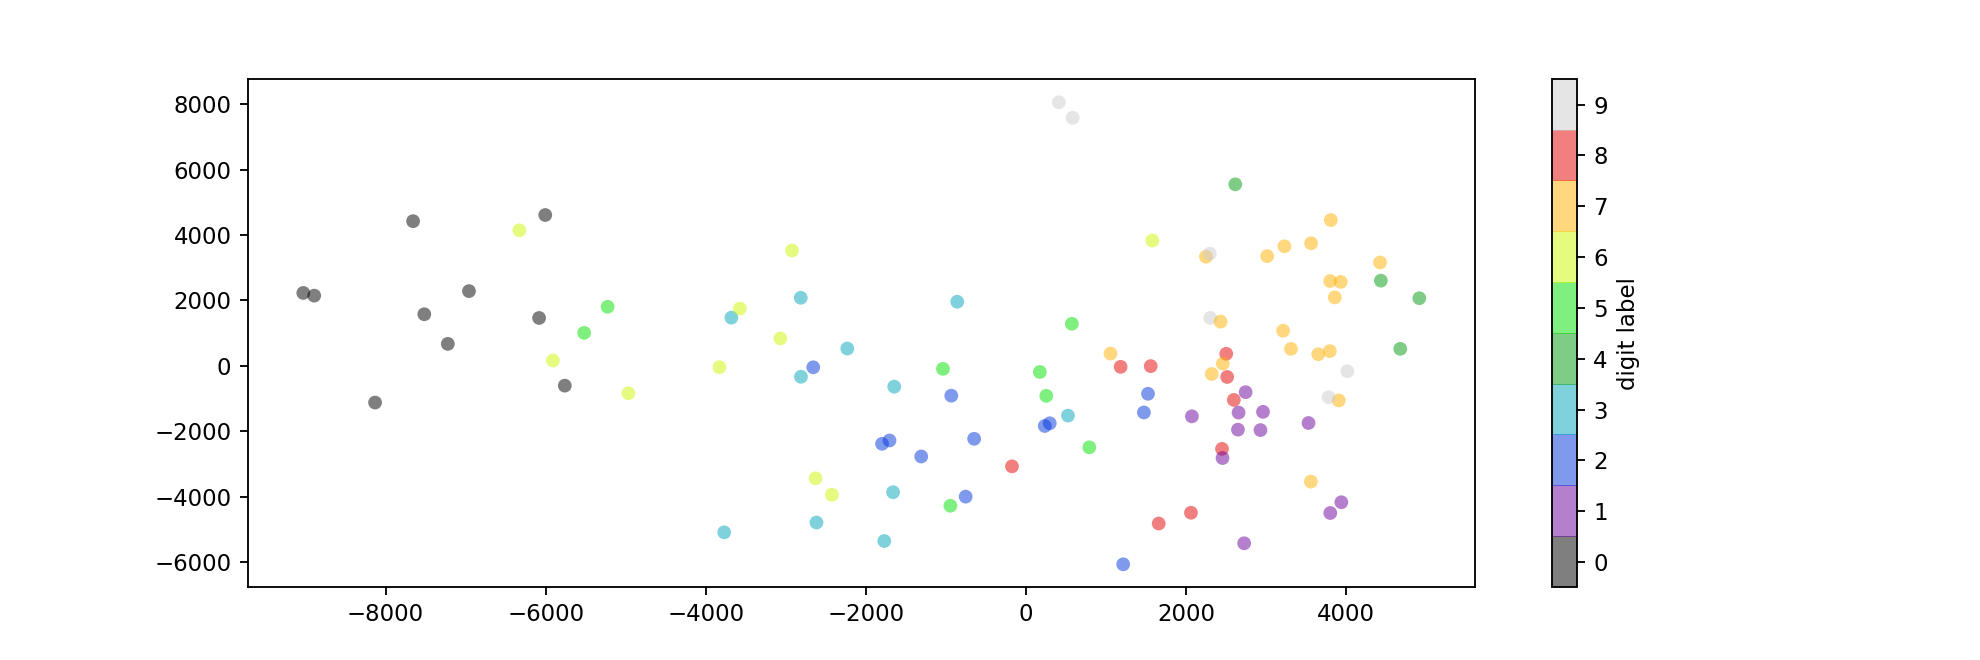

In [29]:
%matplotlib notebook
plt.scatter(data_projected[:,0], data_projected[:,1], c=y_validation[:100], edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('spectral', 10))
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5,9.5);

In [83]:
#from sklearn.manifold import Isomap
#data_to_plot = x_validation[y_validation==1][::100]
#fig, ax = plt.subplots(figsize=[10,10])
#model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
#plot_components(data_to_plot, model, images=data_to_plot.reshape((-1,28,28)), ax=ax, thumb_frac=0.05, cmap='gray_r')

In [25]:
from sklearn.naive_bayes import GaussianNB
gaussian_model = GaussianNB()

In [26]:
%time gaussian_model.fit(x_training, y_training)


Wall time: 628 ms


GaussianNB(priors=None)

In [28]:
%time predicted_gaussian = gaussian_model.predict(x_validation)

Wall time: 935 ms


## Results

In [29]:
# This is a dataframe version of sklearn.metrics.classification_report()
def classification_report_df(actual, predicted, precision=3):
    """
    sklearn.metrics has a function classification_report() which is helpful, but it produces
    plain text. We wanted a dataframe. This is how to achieve it.
    """
    clf_rep = metrics.precision_recall_fscore_support(actual, predicted)
    out_dict = {
                 "precision" :clf_rep[0].round(precision)
                ,"recall" : clf_rep[1].round(precision)
                ,"f1-score" : clf_rep[2].round(precision)
                ,"support" : clf_rep[3]
                }
    out_df = pd.DataFrame(out_dict)
    avg_tot = (out_df.apply(lambda x: round(x.mean(), 2) if x.name!="support" else  round(x.sum(), 2)).to_frame().T)
    avg_tot.index = ["avg/total"]
    out_df = out_df.append(avg_tot)
    out_df.support = out_df.support.astype('int')
    return out_df

In [30]:
# Some example functions that can be applied to style dataframes using css
def color_large_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for large enough
    strings, black otherwise.
    """
    color = 'black' if val > 940 else 'red' if val > 50 else 'black'
    return 'color: %s' % color
def bgcolor_large_yellow(val):
    """
    Takes a scalar and returns a string with
    the css property `'background-color: yellow'` for big
    strings, white otherwise.
    """
    color = 'yellow' if val > 100 and val < 940 else '#eeeeee' if val > 50 and val < 900 else 'white'
    return 'background-color: %s' % color

def get_confusion_df(actual, predicted):
    confusion_df = pd.DataFrame(metrics.confusion_matrix( actual, predicted ))
    confusion_df = confusion_df.append(confusion_df.sum(), ignore_index=True)
    confusion_df.index = [0,1,2,3,4,5,6,7,8,9,'totals']
    confusion_df['totals'] = confusion_df.apply(np.sum,axis=1)
    return confusion_df

In [31]:
def color_large(val, thresh, color):
    if val > thresh or val < -thresh:
        return 'color: %s' % color
    else:
        return ''
def bgcolor_large(val, thresh, color):
    """
    Takes a scalar and returns a string with
    the css property `'background-color: yellow'` for big
    strings, white otherwise.
    """
    color = color if val > thresh else 'white'
    return 'background-color: %s' % color

In [33]:
def blank_pixel(width):
    return  '<img src="data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP///yH5BAEAAAAALAAAAAABAAEAAAIBRAA7" align="left" style="width: {}px">'.format(width)

def html_str_for_df(styler, title):
    return ('<font size="-1">' + '<div style="float: left; border: 5px">' 
            + '<b>{}</b>'.format(title) 
            + styler.render() 
            + '</div><font>' 
            + blank_pixel(20))

In [34]:
display_html(HTML(
    html_str_for_df(classification_report_df(y_validation, predicted_gaussian).style, 'Gaussian naive Bayes')
    + html_str_for_df(classification_report_df(y_validation, predicted_svm).style, 'svm')
    + html_str_for_df(classification_report_df(y_validation, predicted_neighbors).style, '3 neighbors')))

display_html(HTML(
    html_str_for_df(get_confusion_df(y_validation, predicted_gaussian).style.applymap(color_large_red).applymap(bgcolor_large_yellow), 'Gaussian NB')
    + html_str_for_df(get_confusion_df(y_validation, predicted_svm).style.applymap(color_large_red).applymap(bgcolor_large_yellow), 'svm')
    + html_str_for_df(get_confusion_df(y_validation, predicted_neighbors).style.applymap(color_large_red).applymap(bgcolor_large_yellow), '3 neighbors')))

Gaussian naive Bayes 
 

 
 

 
 
 
 
 
 
 
 
 
 
 
 f1-score
 
 
 
 
 precision
 
 
 
 
 recall
 
 
 
 
 support
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 0.786
 
 
 
 
 0.685
 
 
 
 
 0.922
 
 
 
 
 1033
 
 
 
 
 
 
 
 
 1
 
 
 
 
 0.831
 
 
 
 
 0.736
 
 
 
 
 0.955
 
 
 
 
 1171
 
 
 
 
 
 
 
 
 2
 
 
 
 
 0.376
 
 
 
 
 0.841
 
 
 
 
 0.242
 
 
 
 
 1044
 
 
 
 
 
 
 
 
 3
 
 
 
 
 0.471
 
 
 
 
 0.701
 
 
 
 
 0.355
 
 
 
 
 1088
 
 
 
 
 
 
 
 
 4
 
 
 
 
 0.196
 
 
 
 
 0.85
 
 
 
 
 0.111
 
 
 
 
 1018
 
 
 
 
 
 
 
 
 5
 
 
 
 
 0.092
 
 
 
 
 0.644
 
 
 
 
 0.05
 
 
 
 
 949
 
 
 
 
 
 
 
 
 6
 
 
 
 
 0.747
 
 
 
 
 0.617
 
 
 
 
 0.947
 
 
 
 
 1034
 
 
 
 
 
 
 
 
 7
 
 
 
 
 0.474
 
 
 
 
 0.886
 
 
 
 
 0.324
 
 
 
 
 1100
 
 
 
 
 
 
 
 
 8
 
 
 
 
 0.401
 
 
 
 
 0.298
 
 
 
 
 0.613
 
 
 
 
 1016
 
 
 
 
 
 
 
 
 9
 
 
 
 
 0.551
 
 
 
 
 0.393
 
 
 
 
 0.922
 
 
 
 
 1047
 
 
 
 
 
 
 
 
 avg/total
 
 
 
 
 0.49
 
 
 
 
 0.67
 
 
 
 
 0.54
 
 
 
 
 10500
 
 
 
 
 
 
 svm 
 

 
 

 
 
 
 
 
 
 
 
 
 
 
 f1-score
 
 
 
 
 precision
 
 
 
 
 recall
 
 
 
 
 support
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 0.947
 
 
 
 
 0.942
 
 
 
 
 0.952
 
 
 
 
 1033
 
 
 
 
 
 
 
 
 1
 
 
 
 
 0.951
 
 
 
 
 0.938
 
 
 
 
 0.964
 
 
 
 
 1171
 
 
 
 
 
 
 
 
 2
 
 
 
 
 0.854
 
 
 
 
 0.923
 
 
 
 
 0.794
 
 
 
 
 1044
 
 
 
 
 
 
 
 
 3
 
 
 
 
 0.864
 
 
 
 
 0.841
 
 
 
 
 0.887
 
 
 
 
 1088
 
 
 
 
 
 
 
 
 4
 
 
 
 
 0.846
 
 
 
 
 0.781
 
 
 
 
 0.922
 
 
 
 
 1018
 
 
 
 
 
 
 
 
 5
 
 
 
 
 0.76
 
 
 
 
 0.912
 
 
 
 
 0.651
 
 
 
 
 949
 
 
 
 
 
 
 
 
 6
 
 
 
 
 0.925
 
 
 
 
 0.923
 
 
 
 
 0.926
 
 
 
 
 1034
 
 
 
 
 
 
 
 
 7
 
 
 
 
 0.889
 
 
 
 
 0.95
 
 
 
 
 0.835
 
 
 
 
 1100
 
 
 
 
 
 
 
 
 8
 
 
 
 
 0.806
 
 
 
 
 0.754
 
 
 
 
 0.867
 
 
 
 
 1016
 
 
 
 
 
 
 
 
 9
 
 
 
 
 0.828
 
 
 
 
 0.79
 
 
 
 
 0.87
 
 
 
 
 1047
 
 
 
 
 
 
 
 
 avg/total
 
 
 
 
 0.87
 
 
 
 
 0.88
 
 
 
 
 0.87
 
 
 
 
 10500
 
 
 
 
 
 
 3 neighbors 
 

 
 

 
 
 
 
 
 
 
 
 
 
 
 f1-score
 
 
 
 
 precision
 
 
 
 
 recall
 
 
 
 
 support
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 0.982
 
 
 
 
 0.972
 
 
 
 
 0.993
 
 
 
 
 1033
 
 
 
 
 
 
 
 
 1
 
 
 
 
 0.973
 
 
 
 
 0.954
 
 
 
 
 0.992
 
 
 
 
 1171
 
 
 
 
 
 
 
 
 2
 
 
 
 
 0.968
 
 
 
 
 0.978
 
 
 
 
 0.957
 
 
 
 
 1044
 
 
 
 
 
 
 
 
 3
 
 
 
 
 0.961
 
 
 
 
 0.956
 
 
 
 
 0.965
 
 
 
 
 1088
 
 
 
 
 
 
 
 
 4
 
 
 
 
 0.966
 
 
 
 
 0.971
 
 
 
 
 0.962
 
 
 
 
 1018
 
 
 
 
 
 
 
 
 5
 
 
 
 
 0.955
 
 
 
 
 0.953
 
 
 
 
 0.957
 
 
 
 
 949
 
 
 
 
 
 
 
 
 6
 
 
 
 
 0.984
 
 
 
 
 0.982
 
 
 
 
 0.985
 
 
 
 
 1034
 
 
 
 
 
 
 
 
 7
 
 
 
 
 0.967
 
 
 
 
 0.964
 
 
 
 
 0.971
 
 
 
 
 1100
 
 
 
 
 
 
 
 
 8
 
 
 
 
 0.96
 
 
 
 
 0.997
 
 
 
 
 0.926
 
 
 
 
 1016
 
 
 
 
 
 
 
 
 9
 
 
 
 
 0.955
 
 
 
 
 0.951
 
 
 
 
 0.959
 
 
 
 
 1047
 
 
 
 
 
 
 
 
 avg/total
 
 
 
 
 0.97
 
 
 
 
 0.97
 
 
 
 
 0.97
 
 
 
 
 10500

Gaussian NB 
 

 
 

 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 1
 
 
 
 
 2
 
 
 
 
 3
 
 
 
 
 4
 
 
 
 
 5
 
 
 
 
 6
 
 
 
 
 7
 
 
 
 
 8
 
 
 
 
 9
 
 
 
 
 totals
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 952
 
 
 
 
 1
 
 
 
 
 5
 
 
 
 
 4
 
 
 
 
 0
 
 
 
 
 0
 
 
 
 
 37
 
 
 
 
 0
 
 
 
 
 23
 
 
 
 
 11
 
 
 
 
 1033
 
 
 
 
 
 
 
 
 1
 
 
 
 
 1
 
 
 
 
 1118
 
 
 
 
 5
 
 
 
 
 7
 
 
 
 
 0
 
 
 
 
 3
 
 
 
 
 9
 
 
 
 
 1
 
 
 
 
 21
 
 
 
 
 6
 
 
 
 
 1171
 
 
 
 
 
 
 
 
 2
 
 
 
 
 123
 
 
 
 
 40
 
 
 
 
 253
 
 
 
 
 112
 
 
 
 
 3
 
 
 
 
 4
 
 
 
 
 280
 
 
 
 
 2
 
 
 
 
 208
 
 
 
 
 19
 
 
 
 
 1044
 
 
 
 
 
 
 
 
 3
 
 
 
 
 80
 
 
 
 
 67
 
 
 
 
 9
 
 
 
 
 386
 
 
 
 
 3
 
 
 
 
 3
 
 
 
 
 74
 
 
 
 
 10
 
 
 
 
 368
 
 
 
 
 88
 
 
 
 
 1088
 
 
 
 
 
 
 
 
 4
 
 
 
 
 42
 
 
 
 
 15
 
 
 
 
 9
 
 
 
 
 4
 
 
 
 
 113
 
 
 
 
 4
 
 
 
 
 109
 
 
 
 
 6
 
 
 
 
 226
 
 
 
 
 490
 
 
 
 
 1018
 
 
 
 
 
 
 
 
 5
 
 
 
 
 143
 
 
 
 
 42
 
 
 
 
 4
 
 
 
 
 17
 
 
 
 
 0
 
 
 
 
 47
 
 
 
 
 70
 
 
 
 
 3
 
 
 
 
 537
 
 
 
 
 86
 
 
 
 
 949
 
 
 
 
 
 
 
 
 6
 
 
 
 
 13
 
 
 
 
 20
 
 
 
 
 5
 
 
 
 
 0
 
 
 
 
 0
 
 
 
 
 4
 
 
 
 
 979
 
 
 
 
 0
 
 
 
 
 13
 
 
 
 
 0
 
 
 
 
 1034
 
 
 
 
 
 
 
 
 7
 
 
 
 
 5
 
 
 
 
 16
 
 
 
 
 3
 
 
 
 
 14
 
 
 
 
 2
 
 
 
 
 1
 
 
 
 
 5
 
 
 
 
 356
 
 
 
 
 56
 
 
 
 
 642
 
 
 
 
 1100
 
 
 
 
 
 
 
 
 8
 
 
 
 
 25
 
 
 
 
 180
 
 
 
 
 3
 
 
 
 
 7
 
 
 
 
 3
 
 
 
 
 5
 
 
 
 
 23
 
 
 
 
 0
 
 
 
 
 623
 
 
 
 
 147
 
 
 
 
 1016
 
 
 
 
 
 
 
 
 9
 
 
 
 
 5
 
 
 
 
 20
 
 
 
 
 5
 
 
 
 
 0
 
 
 
 
 9
 
 
 
 
 2
 
 
 
 
 1
 
 
 
 
 24
 
 
 
 
 16
 
 
 
 
 965
 
 
 
 
 1047
 
 
 
 
 
 
 
 
 totals
 
 
 
 
 1389
 
 
 
 
 1519
 
 
 
 
 301
 
 
 
 
 551
 
 
 
 
 133
 
 
 
 
 73
 
 
 
 
 1587
 
 
 
 
 402
 
 
 
 
 2091
 
 
 
 
 2454
 
 
 
 
 10500
 
 
 
 
 
 
 svm 
 

 
 

 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 1
 
 
 
 
 2
 
 
 
 
 3
 
 
 
 
 4
 
 
 
 
 5
 
 
 
 
 6
 
 
 
 
 7
 
 
 
 
 8
 
 
 
 
 9
 
 
 
 
 totals
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 983
 
 
 
 
 0
 
 
 
 
 0
 
 
 
 
 0
 
 
 
 
 17
 
 
 
 
 4
 
 
 
 
 10
 
 
 
 
 1
 
 
 
 
 12
 
 
 
 
 6
 
 
 
 
 1033
 
 
 
 
 
 
 
 
 1
 
 
 
 
 0
 
 
 
 
 1129
 
 
 
 
 5
 
 
 
 
 3
 
 
 
 
 5
 
 
 
 
 0
 
 
 
 
 2
 
 
 
 
 3
 
 
 
 
 22
 
 
 
 
 2
 
 
 
 
 1171
 
 
 
 
 
 
 
 
 2
 
 
 
 
 6
 
 
 
 
 27
 
 
 
 
 829
 
 
 
 
 28
 
 
 
 
 33
 
 
 
 
 4
 
 
 
 
 14
 
 
 
 
 14
 
 
 
 
 78
 
 
 
 
 11
 
 
 
 
 1044
 
 
 
 
 
 
 
 
 3
 
 
 
 
 8
 
 
 
 
 7
 
 
 
 
 22
 
 
 
 
 965
 
 
 
 
 14
 
 
 
 
 20
 
 
 
 
 3
 
 
 
 
 3
 
 
 
 
 30
 
 
 
 
 16
 
 
 
 
 1088
 
 
 
 
 
 
 
 
 4
 
 
 
 
 3
 
 
 
 
 3
 
 
 
 
 1
 
 
 
 
 4
 
 
 
 
 939
 
 
 
 
 1
 
 
 
 
 5
 
 
 
 
 3
 
 
 
 
 18
 
 
 
 
 41
 
 
 
 
 1018
 
 
 
 
 
 
 
 
 5
 
 
 
 
 21
 
 
 
 
 11
 
 
 
 
 8
 
 
 
 
 78
 
 
 
 
 52
 
 
 
 
 618
 
 
 
 
 41
 
 
 
 
 2
 
 
 
 
 76
 
 
 
 
 42
 
 
 
 
 949
 
 
 
 
 
 
 
 
 6
 
 
 
 
 10
 
 
 
 
 2
 
 
 
 
 10
 
 
 
 
 0
 
 
 
 
 25
 
 
 
 
 6
 
 
 
 
 958
 
 
 
 
 0
 
 
 
 
 21
 
 
 
 
 2
 
 
 
 
 1034
 
 
 
 
 
 
 
 
 7
 
 
 
 
 6
 
 
 
 
 3
 
 
 
 
 10
 
 
 
 
 22
 
 
 
 
 36
 
 
 
 
 4
 
 
 
 
 3
 
 
 
 
 918
 
 
 
 
 11
 
 
 
 
 87
 
 
 
 
 1100
 
 
 
 
 
 
 
 
 8
 
 
 
 
 6
 
 
 
 
 20
 
 
 
 
 12
 
 
 
 
 28
 
 
 
 
 15
 
 
 
 
 14
 
 
 
 
 2
 
 
 
 
 3
 
 
 
 
 881
 
 
 
 
 35
 
 
 
 
 1016
 
 
 
 
 
 
 
 
 9
 
 
 
 
 1
 
 
 
 
 2
 
 
 
 
 1
 
 
 
 
 19
 
 
 
 
 67
 
 
 
 
 7
 
 
 
 
 0
 
 
 
 
 19
 
 
 
 
 20
 
 
 
 
 911
 
 
 
 
 1047
 
 
 
 
 
 
 
 
 totals
 
 
 
 
 1044
 
 
 
 
 1204
 
 
 
 
 898
 
 
 
 
 1147
 
 
 
 
 1203
 
 
 
 
 678
 
 
 
 
 1038
 
 
 
 
 966
 
 
 
 
 1169
 
 
 
 
 1153
 
 
 
 
 10500
 
 
 
 
 
 
 3 neighbors 
 

 
 

 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 1
 
 
 
 
 2
 
 
 
 
 3
 
 
 
 
 4
 
 
 
 
 5
 
 
 
 
 6
 
 
 
 
 7
 
 
 
 
 8
 
 
 
 
 9
 
 
 
 
 totals
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 1026
 
 
 
 
 0
 
 
 
 
 1
 
 
 
 
 1
 
 
 
 
 0
 
 
 
 
 2
 
 
 
 
 2
 
 
 
 
 0
 
 
 
 
 0
 
 
 
 
 1
 
 

## Can we understand the fitted models?
- For the SVM it's just a list of coefficients.
- For the nearest neighbors we'd like to see the neighbors of particular digits, and visually compare.

In [66]:
#help(neighbors.kneighbors)
neighbors.kneighbors(x_validation[1,:])


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


(array([[  853.28541532,  1167.74526332,  1176.7467867 ]]),
 array([[18894, 17799,  9616]], dtype=int64))

In [102]:
print(x_validation[1,:].shape)

(784,)


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


30569


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


18894


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


29582


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


18933


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


27604


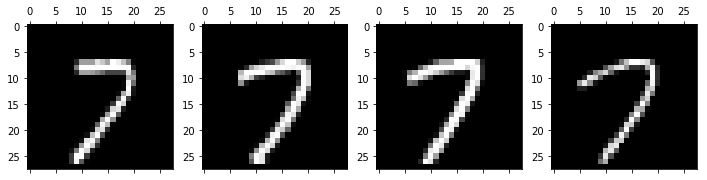

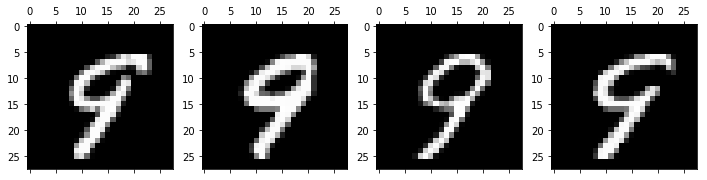

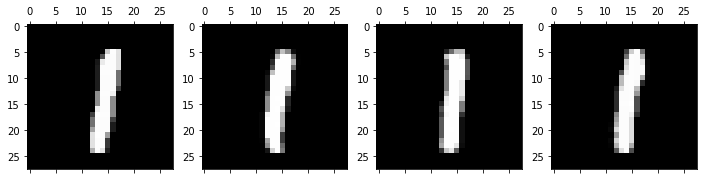

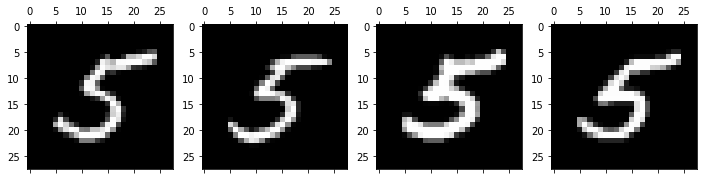

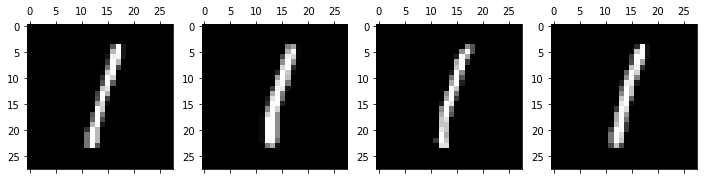

In [104]:
def plot_neighbors(idx):
    my_row = neighbors.kneighbors(x_validation[idx,:])[1][0]
    print(my_row[0])
    my_row = list(my_row) + [idx]
    #my_row = my_row + [[1]]
    #print(my_row)
    plt.figure(figsize=[12,4])
    for i in range(0, 4):
        x = my_row[i]
        plt.subplot(1,4,i+1)
        ax = plt.gca() # get current axis
        if (i != 3):
            ax.matshow(pixel_mat(x, df=training_df), cmap=plt.cm.gray)
        else:
            ax.matshow(pixel_mat(x, df=validation_df), cmap=plt.cm.gray)

for i in range(5):
    plot_neighbors(i)

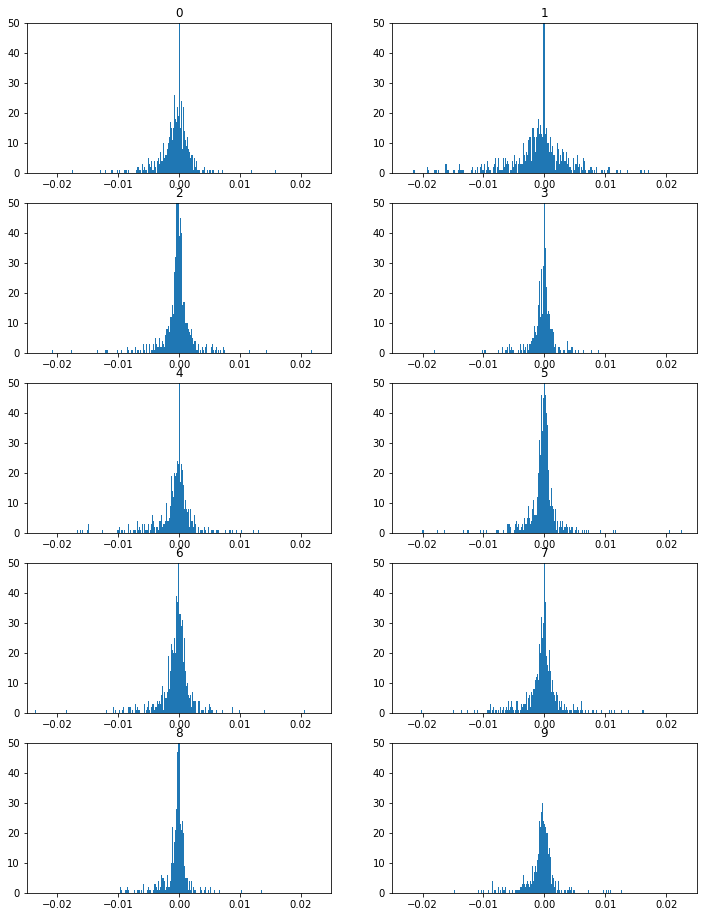

In [107]:
%matplotlib inline
# Here are what the coefficients histogram looks like for the number "3"
def plot_hist(coeffs):
    n = len(coeffs)
    plt.figure(figsize=(12, 16))
    for i, x in enumerate(coeffs):
        plt.subplot(5, 2, i+1)
        plt.hist(x, bins=250)
        ax = plt.gca()
        ax.set_title(i)
        ax.set_xlim([-0.025,0.025])
        ax.set_ylim([0,50])
        #ax.set_ylim([0,100])
        #ax.set_yscale('log')
    plt.show()
plot_hist(linear_svc_classifier.coef_)


In [39]:
print([x*x for x in range(10)])

dot_products = pd.DataFrame(
    np.array([[x_training[j].dot(linear_svc_classifier.coef_[i])
               for i in range(0,10)] for j in range(0,20)]))

dot_products.style.highlight_max(
    axis=1,color='#eeeeff').applymap(
    lambda val: color_large(val, 5, 'red'))

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [40]:
display_html(
    pd.DataFrame(linear_svc_classifier.coef_[3].reshape(28,28)).round(5).style
        .set_precision(3)
        .set_properties(**{'font-size' : '5px', 
                           'padding' : '1px', 
                           'white-space' : 'nowrap'})
        .applymap(lambda val: color_large(val, 0.001, 'blue'))
        .applymap(lambda val: color_large(val, 0.01, 'red'))
        .highlight_max(axis=0,color='#eeeeff')
        .highlight_min(axis=0,color='#ffffee')
)

[[-50 -49 -48 -47 -46 -45 -44 -43 -42 -41]
 [-40 -39 -38 -37 -36 -35 -34 -33 -32 -31]
 [-30 -29 -28 -27 -26 -25 -24 -23 -22 -21]
 [-20 -19 -18 -17 -16 -15 -14 -13 -12 -11]
 [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1]
 [  0   1   2   3   4   5   6   7   8   9]
 [ 10  11  12  13  14  15  16  17  18  19]
 [ 20  21  22  23  24  25  26  27  28  29]
 [ 30  31  32  33  34  35  36  37  38  39]
 [ 40  41  42  43  44  45  46  47  48  49]]


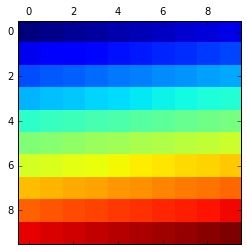

In [79]:
# For reference, these are the colors
%matplotlib inline
print(np.arange(-50,50).reshape(10,10))
plt.gca().matshow(np.arange(-50, 50).reshape(10,10))

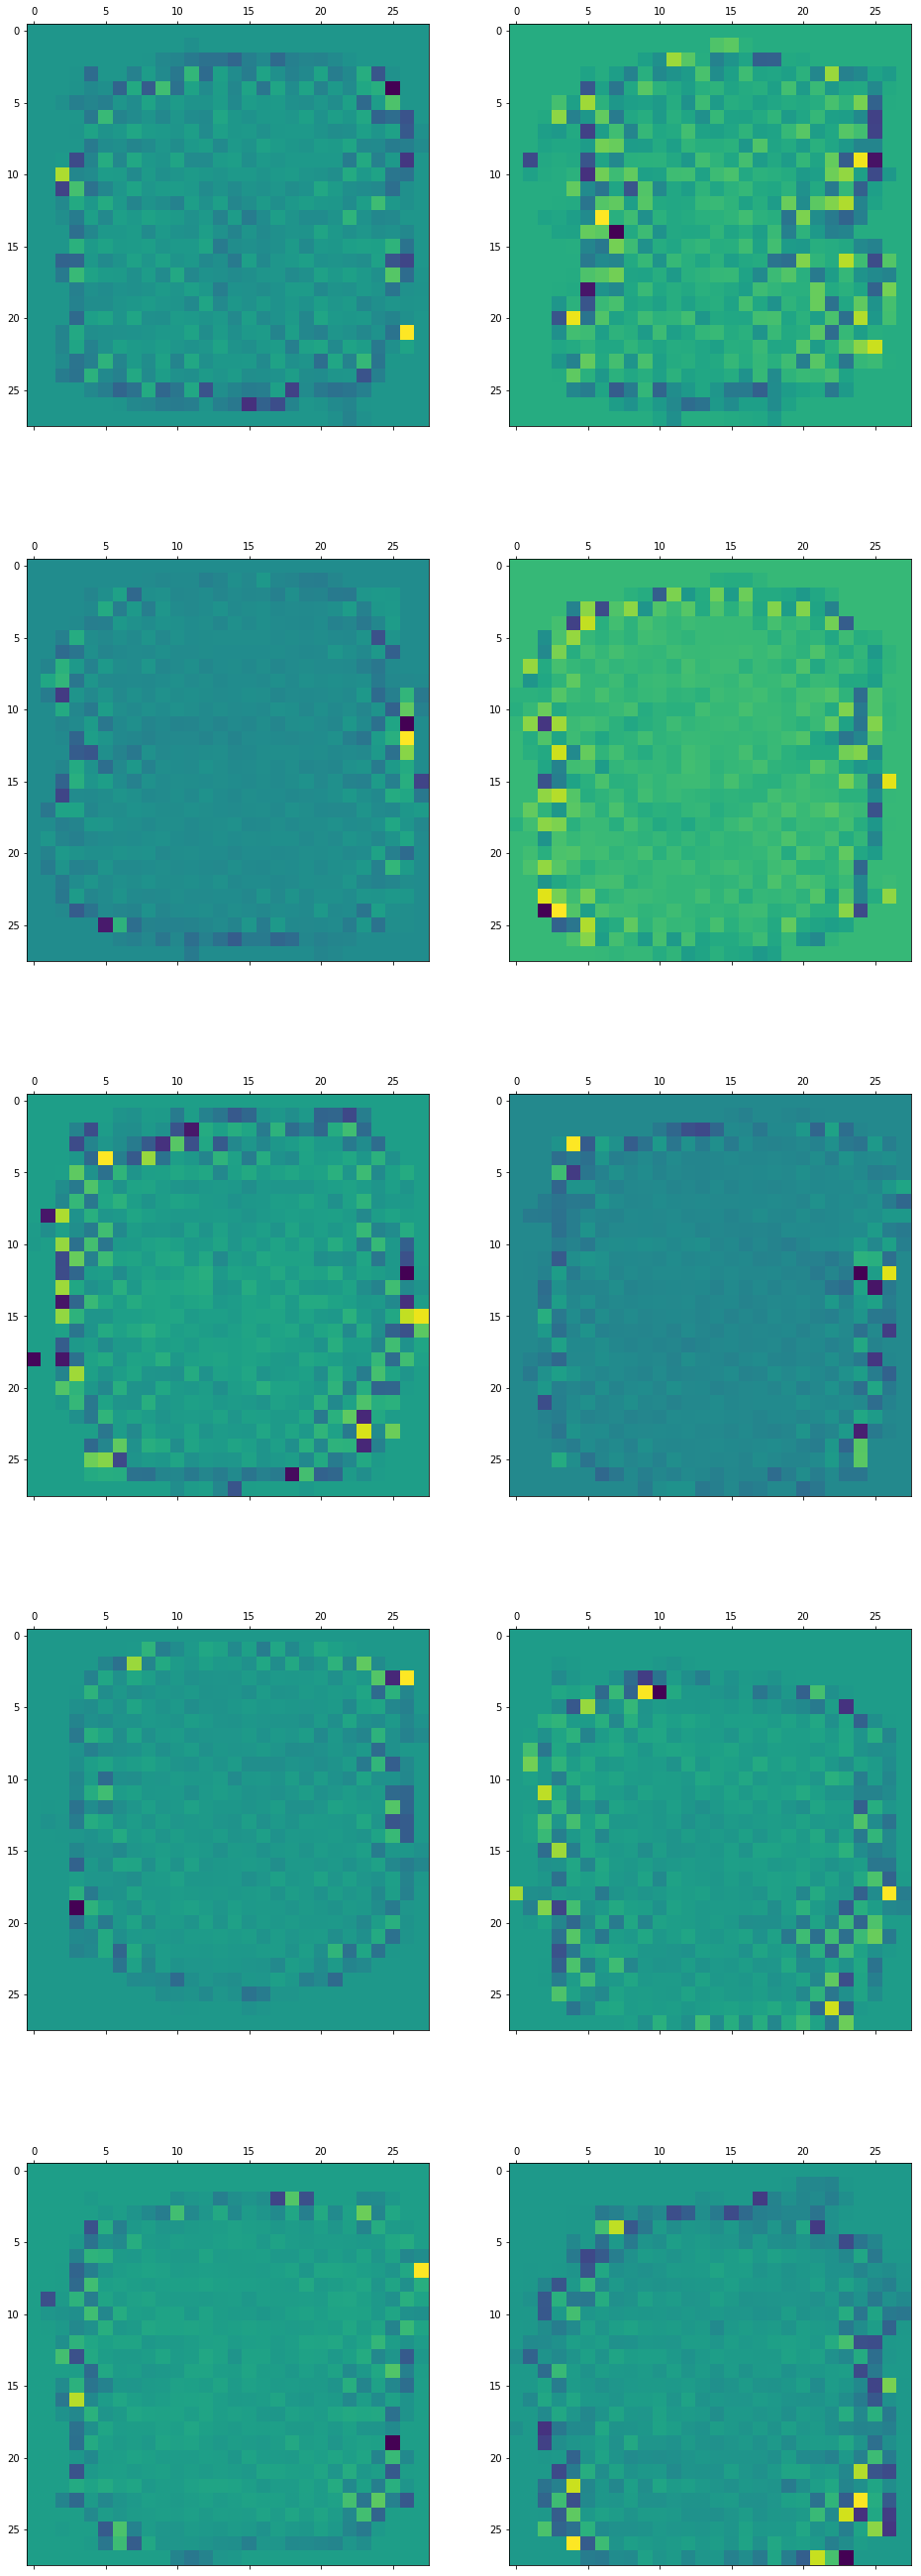

In [41]:
% matplotlib inline
def plot_hyperplanes(coeffs):
    n = len(coeffs)
    plt.figure(figsize=(16, 48))
    for i, x in enumerate(coeffs):
        plt.subplot(5, 2, i+1)
        ax = plt.gca()
        ax.matshow(x.reshape(28,28)*1000000)
        #, cmap=plt.cm.gray)
    plt.show()
plot_hyperplanes(linear_svc_classifier.coef_)

## Another idea: smooth this with a (small) 2d Gaussian blur and see if anything interesting is there

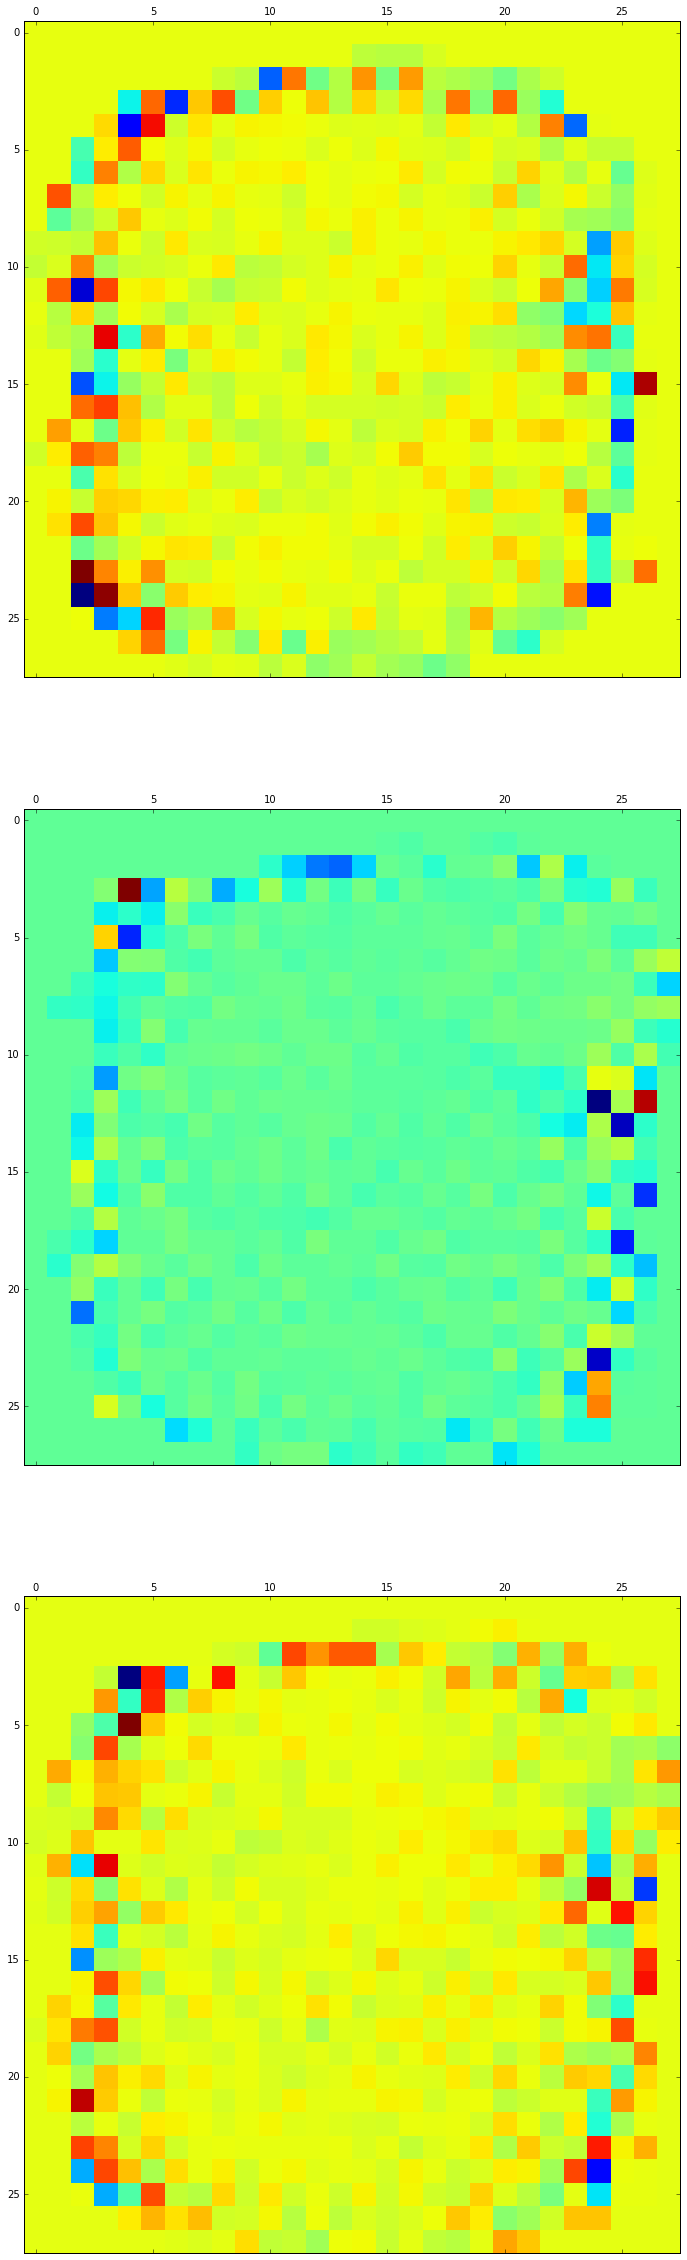

In [168]:
% matplotlib inline
plt.figure(figsize=[16,40])
plt.subplot(3,1,1)
plt.gca().matshow((linear_svc_classifier.coef_[3]).reshape(28,28))
plt.subplot(3,1,2)
plt.gca().matshow((linear_svc_classifier.coef_[5]).reshape(28,28))
plt.subplot(3,1,3)
plt.gca().matshow((linear_svc_classifier.coef_[3]-linear_svc_classifier.coef_[5]).reshape(28,28))


# Different kernels (future work)
* Radial Basis Functions
* Polynomials of degree 2

I'm predicting that the kernel needs to be explicitly aware of the dimensionality of the data. That is, it won't get good
results if it's a symmetric function of all of the indices of the feature vectors. Here are two common kernels, but I suspect they won't be good here.

In [56]:
%%latex
$$K(\mathbf{x}, \mathbf{x'}) = \exp\left(-\frac{\|\mathbf{x} - \mathbf{x'}\|^2}{2\sigma^2}\right)$$

$\sigma$ is a free parameter. An equivalent, but simpler, definition involves a parameter $\textstyle\gamma = \tfrac{1}{2\sigma^2}$:

$$K(\mathbf{x}, \mathbf{x'}) = \exp(-\gamma\|\mathbf{x} - \mathbf{x'}\|^2)$$


<IPython.core.display.Latex object>

In [86]:
classifier_rbf = svm.SVC(kernel='rbf', C=1e3, gamma=0.1)
classifier_poly= svm.SVC(kernel='poly', C=1e3, degree=2)

In [42]:
%%latex

The feature space of the kernel has an infinite number of dimensions; for $\sigma = 1$, it expands to:
\begin{alignat}{2} 
\exp\left(-\frac{1}{2}\|\mathbf{x} - \mathbf{x'}\|^2\right) 
&= \sum_{j=0}^\infty \frac{(\mathbf{x}^\top \mathbf{x'})^j}{j!} \exp\left(-\frac{1}{2}\|\mathbf{x}\|^2\right) \exp\left(-\frac{1}{2}\|\mathbf{x'}\|^2\right)\\
&= \sum_{j=0}^\infty \sum_{\sum n_i=j} 
\exp\left(-\frac{1}{2}\|\mathbf{x}\|^2\right) 
\frac{x_1^{n_1}\cdots x_k^{n_k} }{\sqrt{n_1! \cdots n_k! }} 
\exp\left(-\frac{1}{2}\|\mathbf{x'}\|^2\right) 
\frac{{x'}_1^{n_1}\cdots {x'}_k^{n_k} }{\sqrt{n_1! \cdots n_k! }} 
\end{alignat}


<IPython.core.display.Latex object>

In [43]:
%%latex
The canonical kernel polynomial is defined as

$$K(\mathbf{x},\mathbf{x'}) = (\mathbf{x}^\mathsf{T} \mathbf{x'} + c)^{d}$$

For $d=2$ this can be expanded as
$$K(\mathbf{x},\mathbf{x'}) = \left(\sum_{i=1}^n \mathbf{x}_i \mathbf{x'}_i + c\right)^2 =
\sum_{i=1}^n \left(\mathbf{x}_i^2\right) \left(\mathbf{x'}_i^2 \right) +
\sum_{i=2}^n \sum_{j=1}^{i-1} \left( \sqrt{2} \mathbf{x}_i \mathbf{x}_j \right)
                              \left( \sqrt{2} \mathbf{x'}_i \mathbf{x'}_j \right)
+ \sum_{i=1}^n \left( \sqrt{2c} \mathbf{x}_i \right) \left( \sqrt{2c} \mathbf{x'}_i \right) + c^2$$

<IPython.core.display.Latex object>

In [ ]:
%time classifier_rbf.fit(x_training, y_training)
%time predicted_rbf = classifier_rbf.predict( x_validation )

In [ ]:
%time classifier_poly.fit(x_training, y_training)
%time predicted_poly = classifier_poly.predict( x_validation )

In [ ]:
print( metrics.classification_report( y_validation, predicted_rbf ))
print( metrics.confusion_matrix( y_validation, predicted_rbf ))
print( metrics.classification_report( y_validation, predicted_poly ))
print( metrics.confusion_matrix( y_validation, predicted_poly ))

# How to deploy your own kernel

In [70]:
from sklearn import svm
def my_kernel(X, Y):
    return np.dot(X, Y.T)

my_kernel_classifier = svm.SVC(kernel=my_kernel)

#%time my_kernel_classifier.fit(x_training, y_training)
#%time predicted_with_my_kernel = my_kernel_classifier.predict(x_validation)
